# Parameter tuning

In [1]:
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
import cv2
import tensorflow as tf
from tqdm import tqdm_notebook
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle

/opt/conda/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [2]:
df = pd.read_csv('cat_dog_df.csv')

train_df, test_df = train_test_split(df, test_size=0.2, stratify=df.type)

def df_to_data(df, picsize):
    img_ls = []
    label_ls = []

    for file_name, label in tqdm_notebook(zip(df.file_name, df.type)):
        img = cv2.imread(file_name, cv2.IMREAD_GRAYSCALE)
        img = cv2.resize(img, (picsize, picsize))
        img_ls.append(img)
        
        onehot = np.zeros(2)  
        onehot[label] = 1
        label_ls.append(onehot)

    x_data = np.array(img_ls).reshape(len(df), -1)  # flatten image data
    x_data = x_data / 255.  # normalization
    y_data = np.array(label_ls)
    return x_data, y_data

In [3]:
picsize = 64
X_train, y_train = df_to_data(train_df, picsize)
X_test, y_test = df_to_data(test_df, picsize)

print('size of training data:', X_train.shape, y_train.shape)
print('size of testing data:', X_test.shape, y_test.shape)


size of training data: (20000, 4096) (20000, 2)
size of testing data: (5000, 4096) (5000, 2)


## 1. Early stopping and checkpoint

In [4]:
tf.reset_default_graph()

with tf.name_scope('placeholder'):
    input_data = tf.placeholder(tf.float32, shape=[None, picsize*picsize], name='X')
    y_true = tf.placeholder(tf.float32, shape=[None, 2], name='y')
    
with tf.variable_scope('network'):
    h1 = tf.layers.dense(input_data, 256, activation=tf.nn.relu, name='hidden1') 
    h2 = tf.layers.dense(h1, 128, activation=tf.nn.relu, name='hidden2') 
    h3 = tf.layers.dense(h2, 64, activation=tf.nn.relu, name='hidden3')
    out = tf.layers.dense(h3, 2, name='output')
    
with tf.name_scope('loss'):
    loss = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits_v2(labels=y_true, logits=out), name='loss')
    
with tf.name_scope('accuracy'):
    correct_prediction = tf.equal(tf.argmax(tf.nn.softmax(out), 1), tf.argmax(y_true, 1))
    compute_acc = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))
    
with tf.name_scope('opt'):
    update = tf.train.GradientDescentOptimizer(learning_rate=0.001).minimize(loss)
    
saver = tf.train.Saver()
    
init = tf.global_variables_initializer()

In [6]:
epoch = 100
bs = 32

train_loss_epoch, train_acc_epoch = [], []
test_loss_epoch, test_acc_epoch = [], []

sess = tf.Session()
sess.run(init)

best_loss = 1.
patience = 5
count = 0

for i in tqdm_notebook(range(epoch)):
    
#     training part
    train_loss_batch, train_acc_batch = [], []
    
    total_batch = len(X_train) // bs
    
    for j in range(total_batch):
        
        X_batch = X_train[j*bs : (j+1)*bs]
        y_batch = y_train[j*bs : (j+1)*bs]
        batch_loss, batch_acc, _ = sess.run([loss, compute_acc, update], 
                                            feed_dict={input_data: X_batch, y_true: y_batch})
        
        train_loss_batch.append(batch_loss)
        train_acc_batch.append(batch_acc)
        
    train_loss_epoch.append(np.mean(train_loss_batch))
    train_acc_epoch.append(np.mean(train_acc_batch))
    
#     testing part
    batch_loss, batch_acc = sess.run([loss, compute_acc], 
                                     feed_dict={input_data: X_test, y_true: y_test})

    test_loss_epoch.append(batch_loss)
    test_acc_epoch.append(batch_acc)
    
    X_train, y_train = shuffle(X_train, y_train)
    
    if i%5 == 0:
        print('step: {:2d}, train loss: {:.3f}, train acc: {:.3f}, test loss: {:.3f}, test acc: {:.3f}'
             .format(i, train_loss_epoch[i], train_acc_epoch[i], test_loss_epoch[i], test_acc_epoch[i]))
        
    if batch_loss < best_loss:
        best_loss = batch_loss
        saver.save(sess, './cd_class/bestweight.ckpt', global_step=i)
        count = 0  
    else:
        count += 1
    
    if count >= patience:
        print("The model didn't improve for {} rounds, break it!".format(patience))
        break

step:  0, train loss: 0.686, train acc: 0.549, test loss: 0.677, test acc: 0.578
step:  5, train loss: 0.657, train acc: 0.609, test loss: 0.653, test acc: 0.615
step: 10, train loss: 0.644, train acc: 0.625, test loss: 0.644, test acc: 0.628
step: 15, train loss: 0.634, train acc: 0.641, test loss: 0.640, test acc: 0.629
step: 20, train loss: 0.624, train acc: 0.649, test loss: 0.640, test acc: 0.632
step: 25, train loss: 0.615, train acc: 0.663, test loss: 0.638, test acc: 0.634
step: 30, train loss: 0.606, train acc: 0.672, test loss: 0.629, test acc: 0.641
step: 35, train loss: 0.595, train acc: 0.680, test loss: 0.630, test acc: 0.638
The model didn't improve for 5 rounds, break it!


In [7]:
saver.restore(sess, tf.train.latest_checkpoint('./cd_class'))  
# saver.restore(sess, './cd_class/bestweight.ckpt-XX')
print(sess.run(loss, feed_dict={input_data: X_test, y_true: y_test}))

INFO:tensorflow:Restoring parameters from ./cd_class/bestweight.ckpt-30
0.6287537


In [8]:
sess.close()

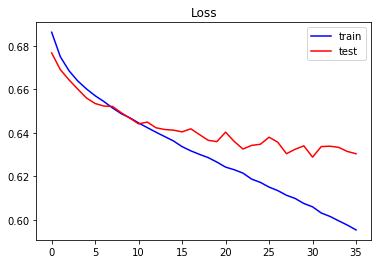

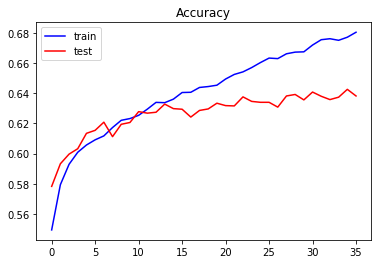

In [9]:
plt.plot(train_loss_epoch, 'b', label='train')
plt.plot(test_loss_epoch, 'r', label='test')
plt.legend()
plt.title("Loss")
plt.show()

plt.plot(train_acc_epoch, 'b', label='train')
plt.plot(test_acc_epoch, 'r', label='test')
plt.legend()
plt.title("Accuracy")
plt.show()

## 2. Regularization

### $$ L(x, y) = L'(x, y) + \lambda \sum_{i=1}^n \theta_{i}^2 $$

In [14]:
tf.reset_default_graph()

with tf.name_scope('placeholder'):
    input_data = tf.placeholder(tf.float32, shape=[None, picsize*picsize], name='X')
    y_true = tf.placeholder(tf.float32, shape=[None, 2], name='y')
    l2 = tf.placeholder(tf.float32, shape=[], name='l2_regulizer')
    #作正規化
with tf.variable_scope('network'):
    h1 = tf.layers.dense(input_data, 256, activation=tf.nn.relu, name='hidden1',
                         kernel_regularizer=tf.contrib.layers.l2_regularizer(scale=l2)) 
    h2 = tf.layers.dense(h1, 128, activation=tf.nn.relu, name='hidden2',
                         kernel_regularizer=tf.contrib.layers.l2_regularizer(scale=l2)) 
    h3 = tf.layers.dense(h2, 64, activation=tf.nn.relu, name='hidden3',
                         kernel_regularizer=tf.contrib.layers.l2_regularizer(scale=l2))
    out = tf.layers.dense(h3, 2, name='output',
                          kernel_regularizer=tf.contrib.layers.l2_regularizer(scale=l2))
    
with tf.name_scope('loss'):
    cross_loss = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits_v2(labels=y_true, logits=out), 
                                name='cross_entropy')
    reg = tf.get_collection(tf.GraphKeys.REGULARIZATION_LOSSES)
    loss = cross_loss + tf.reduce_sum(reg)
    
with tf.name_scope('accuracy'):
    correct_prediction = tf.equal(tf.argmax(tf.nn.softmax(out), 1), tf.argmax(y_true, 1))
    compute_acc = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))
    
with tf.name_scope('opt'):
    update = tf.train.GradientDescentOptimizer(learning_rate=0.001).minimize(loss)
    
init = tf.global_variables_initializer()

In [15]:
reg

[<tf.Tensor 'network/hidden1/kernel/Regularizer/l2_regularizer:0' shape=() dtype=float32>,
 <tf.Tensor 'network/hidden2/kernel/Regularizer/l2_regularizer:0' shape=() dtype=float32>,
 <tf.Tensor 'network/hidden3/kernel/Regularizer/l2_regularizer:0' shape=() dtype=float32>,
 <tf.Tensor 'network/output/kernel/Regularizer/l2_regularizer:0' shape=() dtype=float32>]

In [12]:
history = {}
for l2_reg in [0, 0.1, 0.01, 0.001]:
    
    epoch = 100
    bs = 32

    train_loss_epoch, train_acc_epoch = [], []
    test_loss_epoch, test_acc_epoch = [], []

    sess = tf.Session()
    sess.run(init)

    for i in tqdm_notebook(range(epoch)):

    #     training part
        train_loss_batch, train_acc_batch = [], []

        total_batch = len(X_train) // bs

        for j in range(total_batch):

            X_batch = X_train[j*bs : (j+1)*bs]
            y_batch = y_train[j*bs : (j+1)*bs]
            batch_loss, batch_acc, _ = sess.run([loss, compute_acc, update], 
                                                feed_dict={input_data: X_batch, y_true: y_batch, l2: l2_reg})

            train_loss_batch.append(batch_loss)
            train_acc_batch.append(batch_acc)

        train_loss_epoch.append(np.mean(train_loss_batch))
        train_acc_epoch.append(np.mean(train_acc_batch))

    #     testing part
        batch_loss, batch_acc = sess.run([loss, compute_acc], 
                                         feed_dict={input_data: X_test, y_true: y_test, l2: l2_reg})

        test_loss_epoch.append(batch_loss)
        test_acc_epoch.append(batch_acc)

        X_train, y_train = shuffle(X_train, y_train)
        
    sess.close()
    
    history[l2_reg] = [train_loss_epoch, train_acc_epoch, test_loss_epoch, test_acc_epoch]

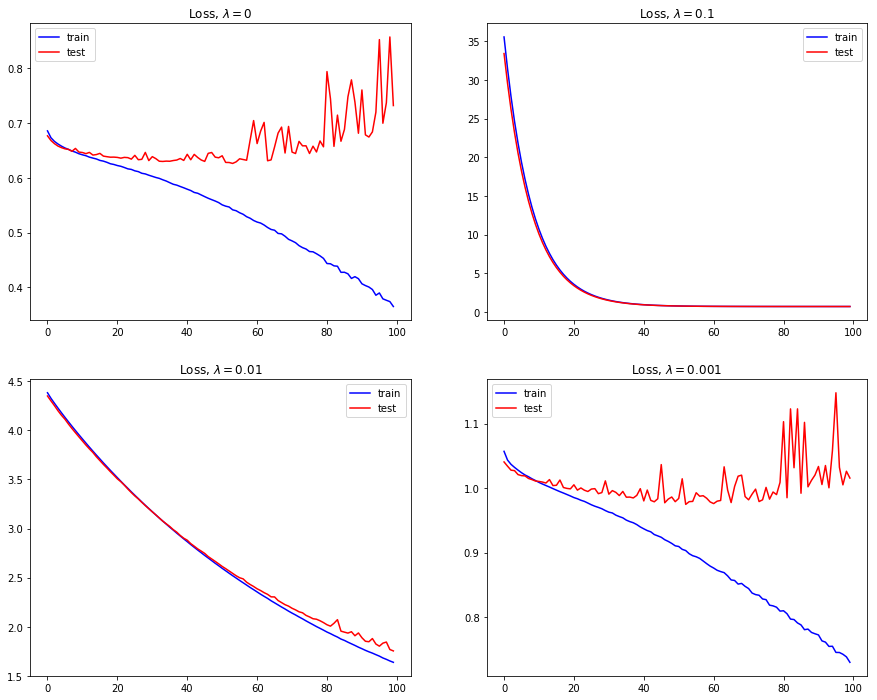

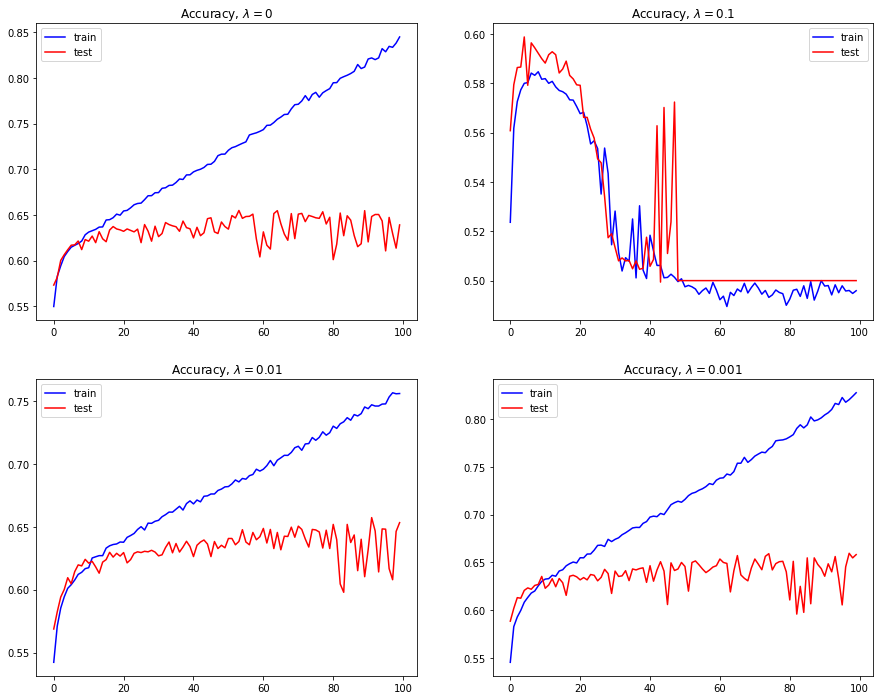

In [16]:
fig, axes = plt.subplots(2, 2, figsize=(15, 12))
axes = axes.ravel()
for ax, key in zip(axes, history.keys()):
    ax.plot(history[key][0], 'b', label='train')
    ax.plot(history[key][2], 'r', label='test')
    ax.set_title('Loss, $\lambda = {}$'.format(key))
    ax.legend()
    
fig, axes = plt.subplots(2, 2, figsize=(15, 12))
axes = axes.ravel()
for ax, key in zip(axes, history.keys()):
    ax.plot(history[key][1], 'b', label='train')
    ax.plot(history[key][3], 'r', label='test')
    ax.set_title('Accuracy, $\lambda = {}$'.format(key))
    ax.legend()

## 3. Dropout

<img src="pics/dropout.png" width="800">

In [17]:
tf.reset_default_graph()

with tf.name_scope('placeholder'):
    input_data = tf.placeholder(tf.float32, shape=[None, picsize*picsize], name='X')
    y_true = tf.placeholder(tf.float32, shape=[None, 2], name='y')
    dropout = tf.placeholder(tf.float32, shape=[], name='dropout')
    training = tf.placeholder(tf.bool, name='training')
    
with tf.variable_scope('network'):
    #training=false, 不會執行dropout
    input_drop = tf.layers.dropout(inputs=input_data, rate=dropout, training=training, name='input_drop')
    
    h1 = tf.layers.dense(input_drop, 256, activation=tf.nn.relu, name='hidden1')
    h1 = tf.layers.dropout(h1, rate=dropout, training=training, name='h1_drop')
    
    h2 = tf.layers.dense(h1, 128, activation=tf.nn.relu, name='hidden2') 
    h2 = tf.layers.dropout(h2, rate=dropout, training=training, name='h2_drop')
    
    h3 = tf.layers.dense(h2, 64, activation=tf.nn.relu, name='hidden3')
    
    out = tf.layers.dense(h3, 2, name='output')
    
with tf.name_scope('loss'):
    loss = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits_v2(labels=y_true, logits=out), name='loss')
    
with tf.name_scope('accuracy'):
    correct_prediction = tf.equal(tf.argmax(tf.nn.softmax(out), 1), tf.argmax(y_true, 1))
    compute_acc = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))
    
with tf.name_scope('opt'):
    update = tf.train.GradientDescentOptimizer(learning_rate=0.1).minimize(loss)
    
init = tf.global_variables_initializer()

In [18]:
history = {}
for droprate in [0, 0.25, 0.5, 0.75]:
    
    epoch = 100
    bs = 32

    train_loss_epoch, train_acc_epoch = [], []
    test_loss_epoch, test_acc_epoch = [], []

    sess = tf.Session()
    sess.run(init)

    for i in tqdm_notebook(range(epoch)):

    #     training part
        train_loss_batch, train_acc_batch = [], []

        total_batch = len(X_train) // bs

        for j in range(total_batch):

            X_batch = X_train[j*bs : (j+1)*bs]
            y_batch = y_train[j*bs : (j+1)*bs]
            batch_loss, batch_acc, _ = sess.run([loss, compute_acc, update], 
                                                feed_dict={input_data: X_batch, y_true: y_batch, 
                                                           dropout: droprate, training: True})

            train_loss_batch.append(batch_loss)
            train_acc_batch.append(batch_acc)

        train_loss_epoch.append(np.mean(train_loss_batch))
        train_acc_epoch.append(np.mean(train_acc_batch))

    #     testing part
    #     droprate:迴圈設計的參數
    #     traininging:false, 不用訓練資料
        batch_loss, batch_acc = sess.run([loss, compute_acc], 
                                         feed_dict={input_data: X_test, y_true: y_test, 
                                                    dropout: droprate, training: False})

        test_loss_epoch.append(batch_loss)
        test_acc_epoch.append(batch_acc)

        X_train, y_train = shuffle(X_train, y_train)
        
    sess.close()
    
    history[droprate] = [train_loss_epoch, train_acc_epoch, test_loss_epoch, test_acc_epoch]

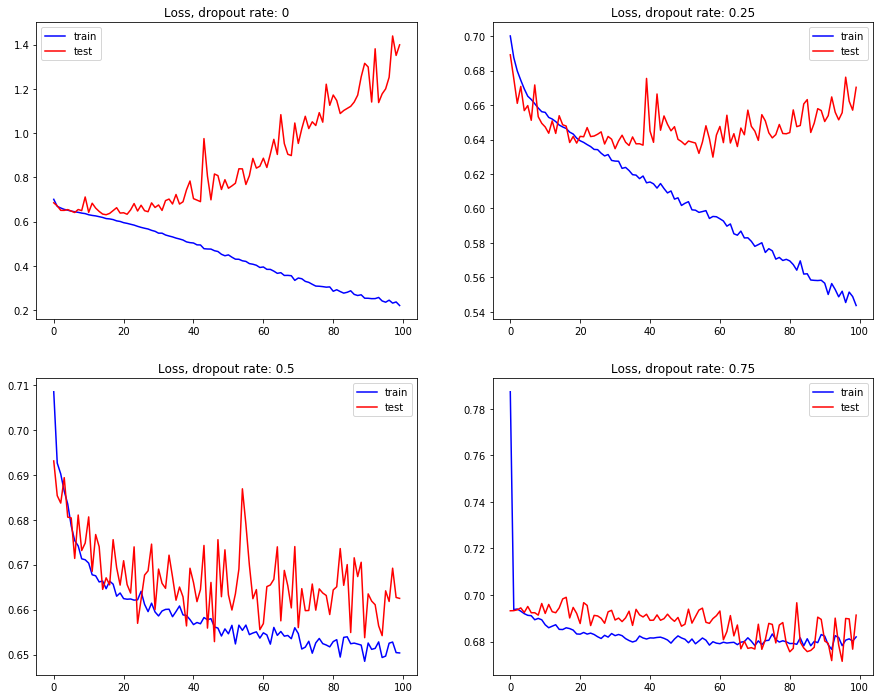

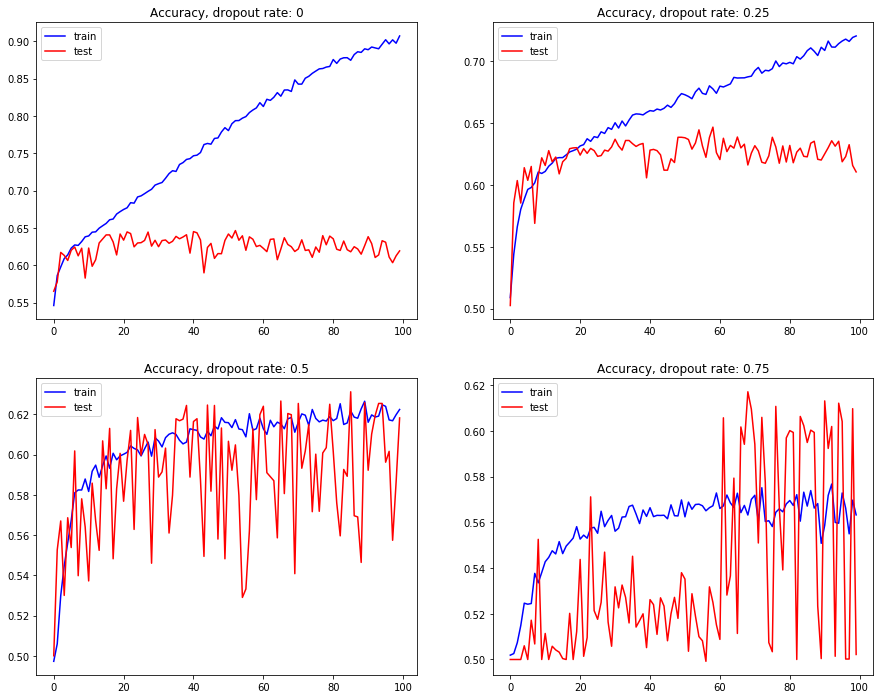

In [19]:
fig, axes = plt.subplots(2, 2, figsize=(15, 12))
axes = axes.ravel()
for ax, key in zip(axes, history.keys()):
    ax.plot(history[key][0], 'b', label='train')
    ax.plot(history[key][2], 'r', label='test')
    ax.set_title('Loss, dropout rate: {}'.format(key))
    ax.legend()
    
fig, axes = plt.subplots(2, 2, figsize=(15, 12))
axes = axes.ravel()
for ax, key in zip(axes, history.keys()):
    ax.plot(history[key][1], 'b', label='train')
    ax.plot(history[key][3], 'r', label='test')
    ax.set_title('Accuracy, dropout rate: {}'.format(key))
    ax.legend()